In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

### Load tokenized tweets

In [3]:
with open('../data/tweets_tokenized.pickle', 'rb') as f:
    tweets_tokenized = pickle.load(f)

### Load word2vec model

In [4]:
w2v_model = Word2Vec.load("../models/w2v_skipgram_w4.model")

### Embedd tweets

- First define a function that adds the individual words in each tweet together to form a vector representation of each tweet.

In [5]:
# This function embedds tweets based on the sum of the vector representations of each word in the tweet
def embed_w2v_sum(tokens, w2v):
    
    # Get the index of the word vectors for each token in a tweet
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    
    # N is the number of tokens in tweet
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    
    # A tweet is represented by the sum of the vectors it contains
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0) 
    
    # Standardize the whole tweet by its norm
    a /= np.linalg.norm(a)
    return a


In [6]:
# Use the function to embedd the tweets
tweets_embedded = np.array([embed_w2v_sum(t, w2v_model) for t in tweets_tokenized])

In [7]:
# Loading the full tweet data
with open('../data/tweets_preprocessed.pickle', 'rb') as f:
    tweet_df = pickle.load(f)

In [8]:
# Add embedded tweets as new column in data frame
cols = [str(i) + "_dim" for i in range(0,tweets_embedded.shape[1])]

# Embedding df
embedding_df = pd.DataFrame(tweets_embedded,columns = cols, index= tweet_df.index)

In [9]:
# Remove some unwanted stuff
cols_to_keep = ["userid", "user_screen_name","user_display_name","follower_count",
                "tweet_text","is_retweet","retweet_count","hashtags"]

tweet_df = tweet_df.loc[:,cols_to_keep].copy()

In [10]:
# Clean up workspace
import gc

del tweets_tokenized

gc.collect()

7

In [11]:
# Join
tweets_final = tweet_df.join(embedding_df)

In [12]:
# Again garbage collection
del tweets_embedded, tweet_df, embedding_df

gc.collect()

21

In [13]:
# Pickle - Tweets
with open('../data/tweets_final.pickle', 'wb') as f:
    pickle.dump(tweets_final, f)



## Visualize and Cluster Embedded Tweets

Let's start with taking some very interesting and/or offensive tweets and finding the most similar as well as dissimilar tweets to them.

We should also work on a subset, so let's take tweets with a higher number of retweets.

Let's visualize some tweets first. We pick out two important accounts: KaniJJackson and Pamela_Moore13

In [33]:
from utils.comparison import embedd_tSNE

In [15]:
# Get the corresponding subsets of the tweet df and embedded tweets, we will work with those now
subset = tweets_final[(tweets_final.user_screen_name == "KaniJJackson") | (tweets_final.user_screen_name == "Pamela_Moore13")].copy()

Let's try to visualize this subset, maybe we already get a separation.

In [16]:
# Get columns of embeddings
X = subset.loc[:,subset.columns[-100:]].values

In [17]:
# Embedd
d = embedd_tSNE(X,pca_n =10, metric='cosine')

starting PCA
Done with PCA


In [18]:
subset["x"] = d[:,0]
subset["y"] = d[:,1]

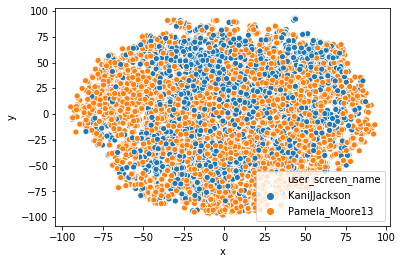

In [19]:
sns.scatterplot(data=subset, x= "x", y="y", hue = "user_screen_name")

Well this is really anything but a separation. On the other hand, project these tweets in two dimensions is really hard. t-SNE is really not supposed to be used for clustering, rather for visualization. Further, I think t-SNE picks up the hashtags (as intended to) which can be shared across users. Let's verify this quickly:

starting PCA
Done with PCA


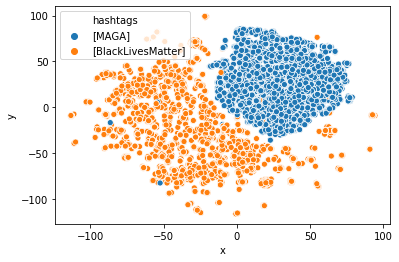

In [20]:
# Get subsets of tweets by hashtag
subset = tweets_final[(tweets_final.hashtags == "[MAGA]") | (tweets_final.hashtags == "[BlackLivesMatter]")].copy()

# Get columns of embeddings
X = subset.loc[:,subset.columns[-100:]].values

# Embedd
d = embedd_tSNE(X,pca_n =10, metric='cosine')

subset["x"] = d[:,0]
subset["y"] = d[:,1]

# Visualize
sns.scatterplot(data=subset, x= "x", y="y", hue = "hashtags")

Interesting, MAGA seems to be one single cluster, whereas BlackLivesMatter consists of many groups. Maybe we can already see polarization inside the BlackLivesMatter topic. It could be that the Russians tried to shape the discussion about race by pushing two sides.

How to continue:

- Cluster all tweets, see whether there are meaningful clusters
- If yes, explore these
- If not, explore single topics, try to find clusters within topics, if there are any, explore these.


### Extracting Hashtags for each tweet

In [5]:
# Fill NaN with string NaN
tweets_final["hashtags"].fillna(value ="NaN", inplace = True)

In [6]:
# Fill '[]' with string NaN
mask = tweets_final[tweets_final.hashtags == '[]'].index

tweets_final.loc[mask,"hashtags"] = "NaN"

In [7]:
hashtags = tweets_final.hashtags.str.extractall(r'(\w+)')

In [83]:
# Pickle - Tweets
with open('../data/hashtags.pickle', 'wb') as f:
    pickle.dump(hashtags, f)



### Visualizing some more hashtags

Let's look at the embeddings by hashtag in more detail.


#### BlackLivesMatter

In [12]:
# Index of tweets containing BlackLivesMatter
blm_idx = hashtags[hashtags[0] == "BlackLivesMatter" ].index.get_level_values(0)

In [36]:
subset = tweets_final.loc[blm_idx,:]
X = subset.loc[:,subset.columns[-100:]].values

In [ ]:
# Embedd
d = embedd_tSNE(X,pca_n =10, metric='cosine')

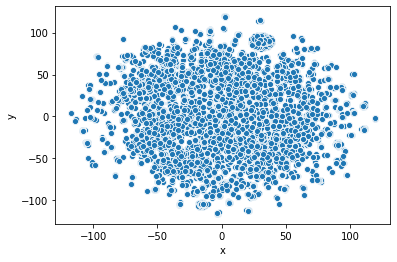

In [37]:

subset["x"] = d[:,0]
subset["y"] = d[:,1]

# Visualize
sns.scatterplot(data=subset, x= "x", y="y")

In [39]:
comparison_idx = hashtags[(hashtags[0] == "BlackLivesMatter") | (hashtags[0] == "BlueLivesMatter") ].index.get_level_values(0)

In [73]:
subset = tweets_final.loc[comparison_idx,:]
X = subset.loc[:,subset.columns[-100:]].values

# Get Hashtags
htag = []

for idx in (comparison_idx):
    
    if ("BlackLivesMatter" in hashtags.loc[idx].values) & ("BlueLivesMatter"  not in hashtags.loc[idx].values) :
        htag.append("blacklivesmatter")
    
    elif ("BlueLivesMatter" in hashtags.loc[idx].values) & ("BlackLivesMatter" not in hashtags.loc[idx].values) :
        htag.append("bluelivesmatter")
    
    else:
        htag.append("both")

In [78]:
subset["htag"] = htag

starting PCA
Done with PCA


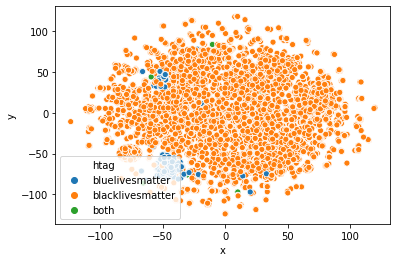

In [79]:
# Embedd
d = embedd_tSNE(X,pca_n =10, metric='cosine')

subset["x"] = d[:,0]
subset["y"] = d[:,1]

# Visualize
sns.scatterplot(data=subset, x= "x", y="y", hue = "htag")